<a href="https://colab.research.google.com/github/AQEEL-AWAN2362/NLP-projects/blob/main/IMDb_Topic_Modeling_(scikit_learn_LDA)_%2B_Sentiment_(TextBlob).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports + NLTK downloads

In [1]:
# core libs
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# text / NLP helpers
from bs4 import BeautifulSoup
from tqdm.auto import tqdm
import nltk
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

# ML / vectorization / LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# sentiment and wordcloud
from textblob import TextBlob
from wordcloud import WordCloud

Load the real IMDb dataset (fast via datasets)

In [2]:
from datasets import load_dataset
ds = load_dataset("imdb")  # official imdb: 25k train, 25k test

# convert to pandas DataFrame
train_df = ds["train"].to_pandas()
test_df  = ds["test"].to_pandas()

# rename for clarity and map labels -> strings
train_df = train_df.rename(columns={"text":"review","label":"sentiment"})
test_df  = test_df.rename(columns={"text":"review","label":"sentiment"})
label_map = {0:"negative", 1:"positive"}
train_df["sentiment"] = train_df["sentiment"].map(label_map)
test_df["sentiment"]  = test_df["sentiment"].map(label_map)

print("Train:", train_df.shape, "Test:", test_df.shape)
train_df.head(2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train: (25000, 2) Test: (25000, 2)


,review,sentiment
0,I rented I AM CURIOUS-YELLOW from my video sto...,negative
1,"""I Am Curious: Yellow"" is a risible and preten...",negative


Data preprocessing and cleaning

In [3]:
stop_words = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

# helper: map NLTK POS tags to WordNet's POS for better lemmatization
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV
def _wn_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return ADJ
    if treebank_tag.startswith('V'):
        return VERB
    if treebank_tag.startswith('N'):
        return NOUN
    if treebank_tag.startswith('R'):
        return ADV
    return NOUN

def clean_text(doc: str) -> str:
    """
    Cleaning pipeline:
    - lowercase
    - strip HTML
    - remove urls, numbers, non-letters
    - tokenize
    - remove stopwords and short tokens
    - POS-aware lemmatize
    - join tokens
    """
    if not isinstance(doc, str):
        return ""
    doc = doc.lower()
    doc = BeautifulSoup(doc, "html.parser").get_text(separator=" ")
    doc = re.sub(r"http\S+|www\.\S+", " ", doc)   # remove urls
    doc = re.sub(r"\d+", " ", doc)                # remove numbers
    doc = re.sub(r"[^a-z\s]", " ", doc)           # keep letters and spaces
    doc = re.sub(r"\s+", " ", doc).strip()        # squeeze spaces
    tokens = word_tokenize(doc)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tagged = pos_tag(tokens)
    lemmas = [LEMMATIZER.lemmatize(tok, _wn_pos(pos)) for tok, pos in tagged]
    return " ".join(lemmas)

Clean train (with progress bar)

In [4]:
sample_df = train_df.sample(2000, random_state=42).copy()
use_df = sample_df

In [5]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

use_df = train_df  # full train set (25k) — can take a few minutes in Colab
tqdm.pandas(desc="Cleaning reviews")
use_df["clean_review"] = use_df["review"].progress_apply(clean_text)

# quick sanity peek
use_df[["review","clean_review","sentiment"]].sample(3, random_state=42)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Cleaning reviews:   0%|          | 0/25000 [00:00<?, ?it/s]

,review,clean_review,sentiment
6868,"Dumb is as dumb does, in this thoroughly unint...",dumb dumb thoroughly uninteresting suppose bla...,negative
24016,I dug out from my garage some old musicals and...,dug garage old musical another one favorites w...,positive
9668,After watching this movie I was honestly disap...,watch movie honestly disappointed actor story ...,negative


Quick checks after cleaning

In [6]:
print("Avg original tokens:", train_df["review"].str.split().str.len().mean())
print("Avg cleaned tokens :", use_df["clean_review"].str.split().str.len().mean())

# Check for empty cleaned rows (rare)
empty_count = (use_df["clean_review"].str.strip() == "").sum()
print("Empty cleaned reviews:", empty_count)

Avg original tokens: 233.7872
Avg cleaned tokens : 117.93136
Empty cleaned reviews: 0


Vectorize using CountVectorizer (Bag-of-Words)

In [7]:
# CountVectorizer often works better for LDA because LDA models counts (word frequencies)
vectorizer = CountVectorizer(max_df=0.90, min_df=10, stop_words="english", ngram_range=(1,1))
X = vectorizer.fit_transform(use_df["clean_review"])

print("Document-Term matrix shape:", X.shape)
vocab = vectorizer.get_feature_names_out()

Document-Term matrix shape: (25000, 14592)


Fit scikit-learn LDA

In [8]:
n_topics = 6  # start with 6; we'll tune later
lda = LatentDirichletAllocation(n_components=n_topics,
                                random_state=42,
                                learning_method="batch",
                                max_iter=10)  # 10 is reasonable to start

lda_topics = lda.fit_transform(X)  # shape: (n_docs, n_topics)
print("lda_topics shape:", lda_topics.shape)

lda_topics shape: (25000, 6)


Display top keywords per topic (detailed)

In [9]:
def display_topics(model, feature_names, no_top_words=12):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append((topic_idx, top_words))
        print(f"Topic {topic_idx}: " + " | ".join(top_words))
    return topics

topics = display_topics(lda, vocab, no_top_words=12)

Topic 0: film | movie | character | story | like | make | great | good | time | love | series | watch
Topic 1: movie | film | like | bad | make | good | watch | really | time | think | say | act
Topic 2: movie | like | play | make | funny | comedy | game | girl | good | old | time | family
Topic 3: film | make | time | play | scene | work | man | director | character | like | great | story
Topic 4: film | movie | make | life | love | time | story | character | great | play | good | people
Topic 5: film | horror | make | movie | like | story | scene | end | character | woman | look | kill


Assign dominant topic to each review

In [10]:
# choose the highest-probability topic for each doc
use_df["topic"] = lda_topics.argmax(axis=1)
# also store the topic probability for the chosen topic (optional but useful)
use_df["topic_prob"] = lda_topics.max(axis=1)

use_df[["clean_review","topic","topic_prob"]].sample(4, random_state=42)

,clean_review,topic,topic_prob
6868,dumb dumb thoroughly uninteresting suppose bla...,2,0.869599
24016,dug garage old musical another one favorites w...,3,0.987957
9668,watch movie honestly disappointed actor story ...,1,0.783141
13640,movie nominate best picture lose casablanca pa...,4,0.785471


Sentiment polarity with TextBlob

In [11]:
tqdm.pandas(desc="Sentiment (TextBlob)")
use_df["polarity"] = use_df["clean_review"].progress_apply(lambda t: TextBlob(t).sentiment.polarity)
# convert polarity to categorical label
def polarity_to_label(p):
    if p > 0.05:
        return "positive"
    if p < -0.05:
        return "negative"
    return "neutral"
use_df["sentiment_pred"] = use_df["polarity"].apply(polarity_to_label)

use_df[["clean_review","polarity","sentiment_pred"]].sample(4, random_state=42)

Sentiment (TextBlob):   0%|          | 0/25000 [00:00<?, ?it/s]

,clean_review,polarity,sentiment_pred
6868,dumb dumb thoroughly uninteresting suppose bla...,-0.051268,negative
24016,dug garage old musical another one favorites w...,0.302027,positive
9668,watch movie honestly disappointed actor story ...,-0.157614,negative
13640,movie nominate best picture lose casablanca pa...,0.504040,positive


Average sentiment per topic

In [12]:
topic_sentiment = use_df.groupby("topic")["polarity"].mean().reset_index().sort_values("topic")
topic_sentiment.columns = ["topic","avg_polarity"]
print(topic_sentiment)

# also counts per topic
topic_counts = use_df["topic"].value_counts().sort_index()
print("\nTopic counts:\n", topic_counts)

   topic  avg_polarity
0      0      0.200997
1      1      0.026557
2      2      0.104212
3      3      0.126480
4      4      0.156933
5      5      0.046458

Topic counts:
 topic
0    4593
1    9435
2    1923
3    2871
4    3083
5    3095
Name: count, dtype: int64


Visualize average sentiment per topic

/tmp/ipython-input-3569066482.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_sentiment, x="topic", y="avg_polarity", palette="coolwarm")


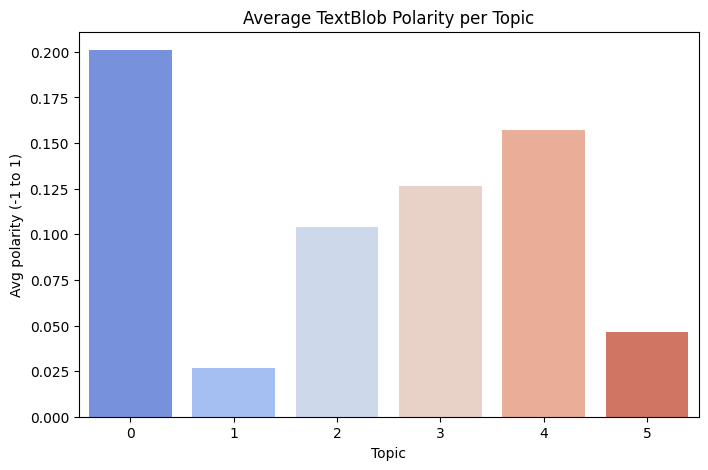

In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data=topic_sentiment, x="topic", y="avg_polarity", palette="coolwarm")
plt.title("Average TextBlob Polarity per Topic")
plt.xlabel("Topic")
plt.ylabel("Avg polarity (-1 to 1)")
plt.axhline(0, color="k", linewidth=0.5)
plt.show()

Wordclouds for each topic

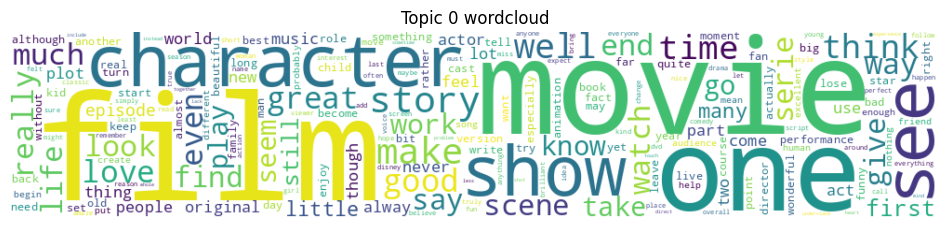

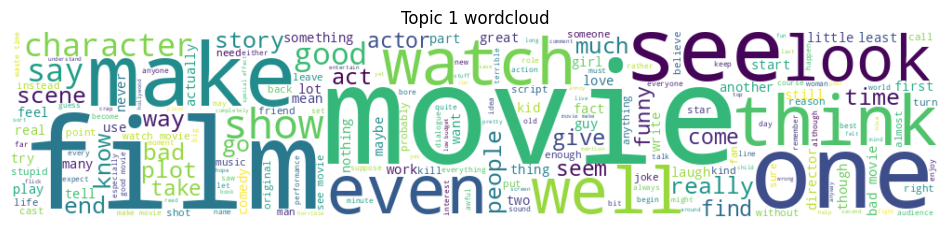

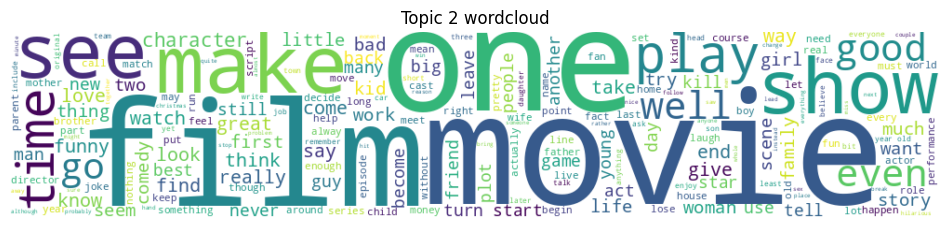

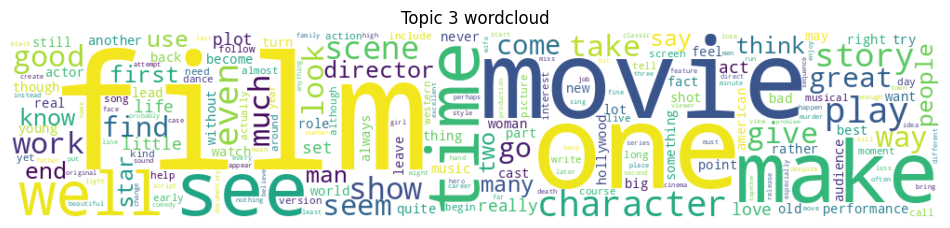

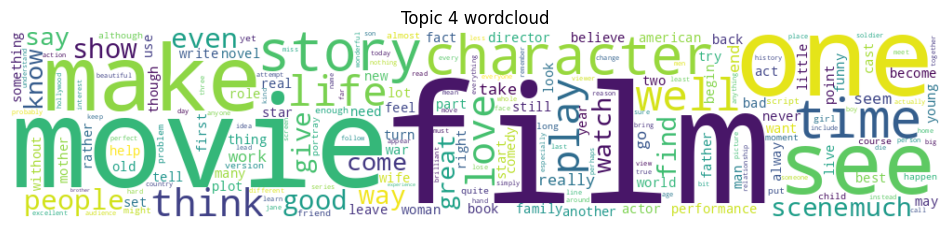

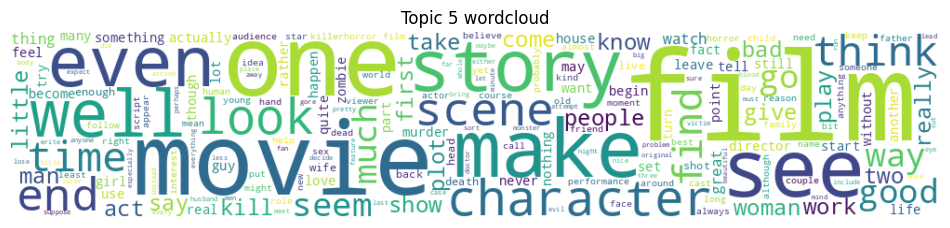

In [14]:
# build text per topic and generate wordclouds
for t_idx, words in topics:
    mask_text = " ".join(use_df.loc[use_df["topic"]==t_idx, "clean_review"].values)
    if len(mask_text.strip()) == 0:
        continue
    wc = WordCloud(width=1000, height=200, background_color="white").generate(mask_text)
    plt.figure(figsize=(12,3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {t_idx} wordcloud")
    plt.show()